# Feature Engineering
_This notebook focuses on transforming raw variables into meaningful features for modeling churn, enhancing predictive power based on EDA insights_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../data/cleaned_data.csv')
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [4]:
print("Dataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nData Info:")
data.info()
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (7043, 20)

Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup 

## Feature Creation

### Create tenure group feature
Splitting tenure into diffrent categories can be useful as we know from EDA that low tenue user has higher chance of churn. Flagging new user appropiately may be an indication toward churn

In [5]:
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 6, 12, 24, 48, 60, 72], labels=['0–6', '6–12', '12–24', '24–48', '48–60', '60–72'])

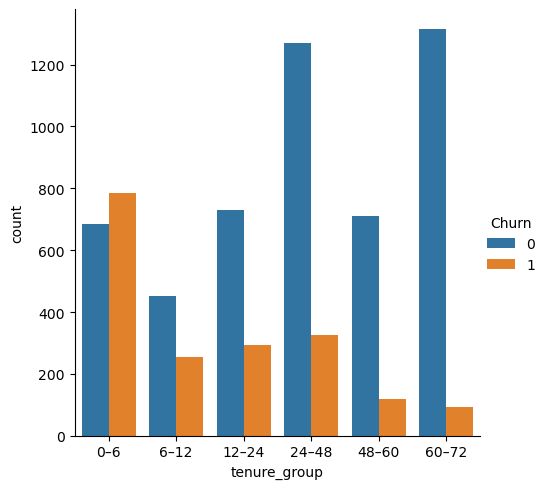

In [6]:
sns.catplot(data, x='tenure_group', hue='Churn', kind='count')

as seen from the visualization, customer with 0-6 tenure has significantly high churn rate, we can create new feature to capture this segment

In [7]:
data['new_customer'] = (data['tenure_group'] == '0–6').astype(int)

### Auto-pay flag
Frictionless payment is key that is correlated with churn rate. Automatic payment lower the tendency to churn

In [8]:
autopay_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
data['is_autopay'] = data['PaymentMethod'].apply(lambda x: 1 if x in autopay_methods else 0)

<Axes: xlabel='is_autopay'>

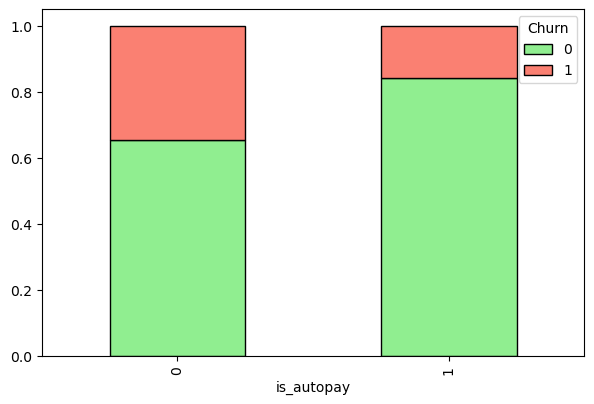

In [9]:
prop_df = (data.groupby(['is_autopay', 'Churn']).size() / data.groupby('is_autopay').size()).unstack().fillna(0)
prop_df.plot(kind='bar', stacked=True, figsize=(7, 4.5), color=['lightgreen', 'salmon'], edgecolor='black')

### Number of services
Number of additional services a user subscribes to represents the customer's ecosystem depth. A low or high number may signal different usage behaviors or cost sensitivities

In [10]:
data['AddOnCount'] = (data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

Furthermore, we can categorized grouping of customers based on number of add-ons. This introduces coarser granularity to AddOnCount, helping identify clusters with shared digital engagement levels

In [11]:
data['AddOnGroup'] = pd.cut(data['AddOnCount'], bins=[-1, 0, 2, 6], labels=['None', 'Low', 'High'])

In [12]:
pd.crosstab(data['AddOnGroup'], data['Churn'])

Churn,0,1
AddOnGroup,,
None,1744,475
Low,1187,812
High,2243,582


### Whether a user has Fiber Optic internet with Streaming TV service
This compound feature may highlight high-bandwidth demand, potentially correlating with premium usage patterns or dissatisfaction if service fails to meet expectations

In [13]:
data['FiberOptic_StreamingTV'] = (data['InternetService'] == 'Fiber optic') & (data['StreamingTV'] == 'Yes')

### Flag for senior citizens on a month-to-month contract
 this group might represent higher churn risk due to flexibility and possibly lower tech affinity

In [14]:
data['Senior_Contract'] = ((data['SeniorCitizen'] == 1) & (data['Contract'] == 'Month-to-month')).astype(int)

### Indicator for users paying significantly high monthly charges
KDE plot from EDA suggest that customer who pays 70+ has high churn likelihood. Therefore, this could be valuable indicator to spot

In [15]:
data['HighMonthlyCharge'] = data['MonthlyCharges'] >= 70

### Binary flag for users on a month-to-month plan and paying via electronic check
This combo captures a known high-risk churn cluster—flexible contracts paired with less secure, less user-friendly payment methods

In [16]:
data["M2M_ElectronicCheck"] = (
    (data["Contract"] == "Month-to-month") & 
    (data["PaymentMethod"] == "Electronic check")
)

### Customer with Fiber Optic internet but no support
this could reflect service vulnerability, increasing the chance of dissatisfaction or dropout

In [17]:
data["Fiber_NoTechSupport"] = (
    (data["InternetService"] == "Fiber optic") & 
    (data["TechSupport"] == "No")
)

### Whether the customer is on a month-to-month contract
these customers lack long-term binding and are typically more frequent churners

In [18]:
data["IsMonthToMonth"] = data["Contract"] == "Month-to-month"

In [19]:
data['ChargePerMonthRatio'] = data['MonthlyCharges'] / data['tenure'].replace(0, 1)

In [20]:
bool_cols = data.select_dtypes(include=["bool"]).columns
data[bool_cols] = data[bool_cols].astype(int)

## Feature Selection and Correlation Analysis

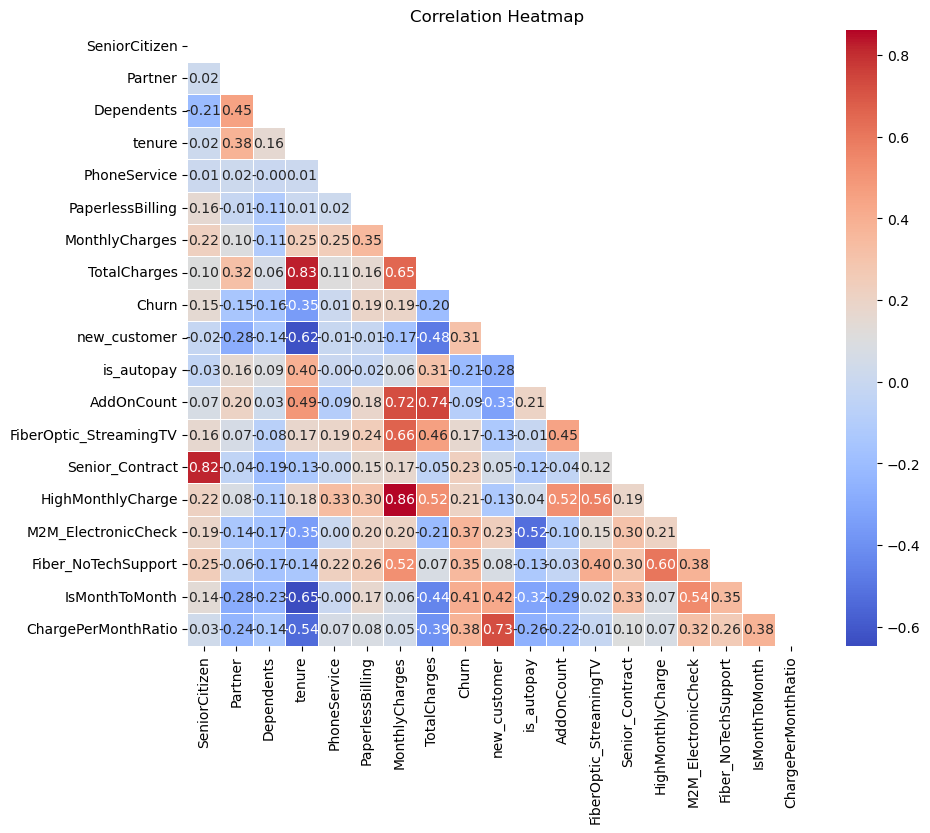

In [21]:
corr_matrix = data.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
from feature_engine.selection import SmartCorrelatedSelection

# List your engineered features
# engineered_features = [
#     'AddOnCount',
#     'FiberOptic_StreamingTV',
#     'Senior_Contract',
#     'HighMonthlyCharge',
#     'M2M_ElectronicCheck',
#     'Fiber_NoTechSupport',
#     'IsMonthToMonth',
#     'AddOnGroup',
#     'ChargePerMonthRatio'
# ]

# Subset the DataFrame
features_pd = data.dropna().select_dtypes(include=['number'])  # Only numeric features

# Instantiate SmartCorrelatedSelection
selector = SmartCorrelatedSelection(
    method='pearson',
    threshold=0.8,
    missing_values='raise',
    selection_method='variance'
)

# Fit to the data
selector.fit(features_pd)

# Print features to drop
print("📉 Features to drop due to high correlation:")
for f in selector.features_to_drop_:
    print(f)


📉 Features to drop due to high correlation:
tenure
HighMonthlyCharge
Senior_Contract


## Feature Engineering Pipeline